# Model Evaluation

Evaluate all wind speed prediction models using the evaluation framework.


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from eval_helpers import evaluate, plot_predictions, compare
from data.data_helpers import get_dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load Data


In [2]:
# Load data
df = get_dataframe()
df = df.dropna(subset=["target_next_hour"])

# Temporal split: 2018-2019 for training, 2020 for testing
train_df = df[df["datetime"] < "2020-01-01"].copy()
test_df = df[df["datetime"] >= "2020-01-01"].copy()

print(f"Training set: {len(train_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

# Store datetime for plotting
test_datetime = test_df["datetime"].copy()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2018_H1.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2018_H2.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2019_H1.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2019_H2.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2020_H1.nc
Skipping existing file /Users/aboulmich/Projects/cis5200-project/data/era5_tehachapi_2020_H2.nc
Training set: 17,520 samples
Test set: 8,783 samples


## Evaluate Models

Evaluate each model and collect results.


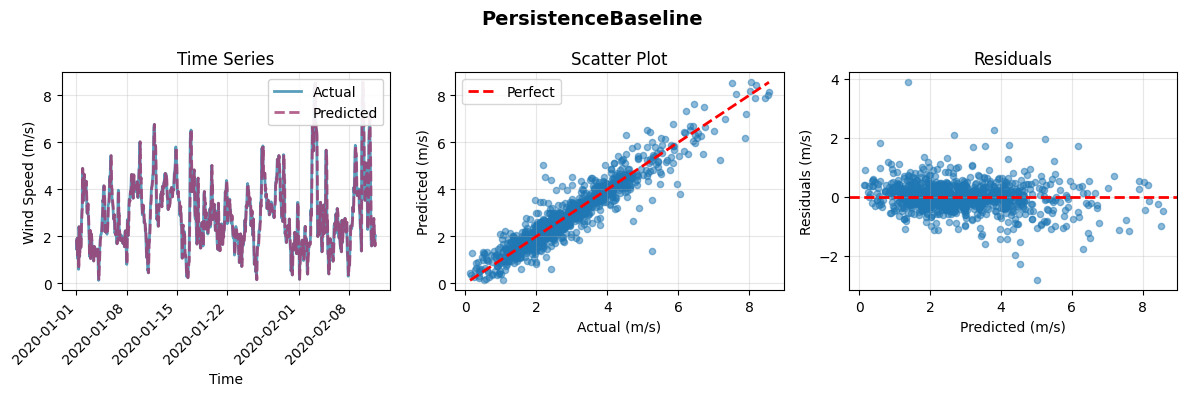


Training XGBoost model...


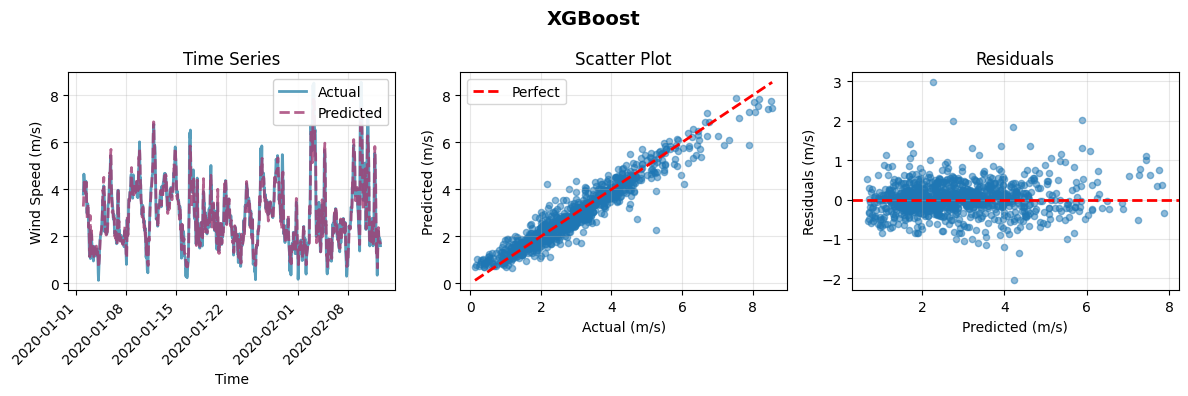


Training MLP model...


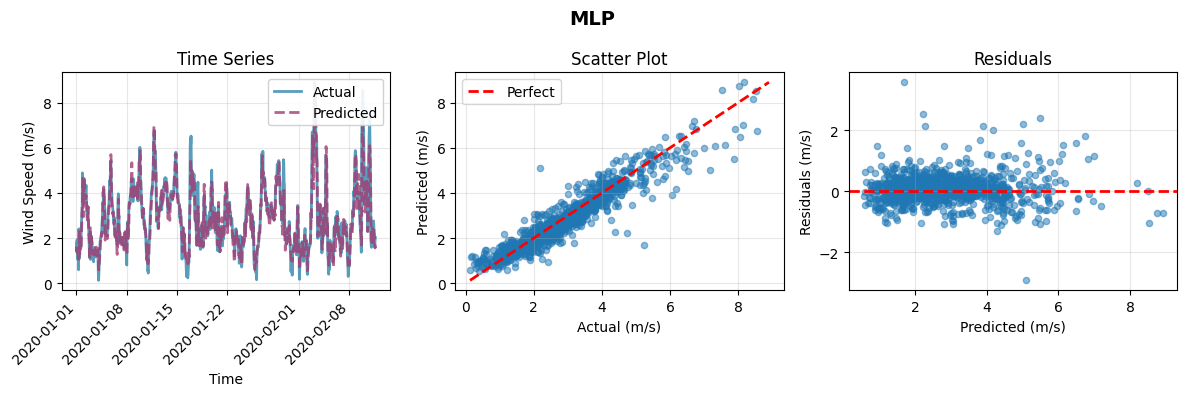

In [3]:
# Collect results from all models
results = []

# Model 0: Persistence Baseline
from models.model0 import PersistenceModel

# Prepare data for model0 (needs wind_speed column)
X_train_m0 = train_df.copy()
y_train_m0 = train_df["target_next_hour"]
X_test_m0 = test_df.copy()
y_test_m0 = test_df["target_next_hour"]

# Evaluate model
model0 = PersistenceModel()
result0 = evaluate(model0, X_train_m0, y_train_m0, X_test_m0, y_test_m0, model_name="PersistenceBaseline")
results.append(result0)

# Plot predictions
plot_predictions(y_test_m0, result0['predictions'], model_name="PersistenceBaseline", datetime_index=test_datetime)
plt.show()

# Model 3: XGBoost
from models.model3 import XGBoostModel

# Prepare data for model3 (needs full dataframe for lagged features)
X_train_m3 = train_df.copy()
y_train_m3 = train_df["target_next_hour"]
X_test_m3 = test_df.copy()
y_test_m3 = test_df["target_next_hour"]

# Evaluate model
print("\nTraining XGBoost model...")
model3 = XGBoostModel()
result3 = evaluate(model3, X_train_m3, y_train_m3, X_test_m3, y_test_m3, model_name="XGBoost")
results.append(result3)

# Plot predictions (handle NaN values from lagged features)
valid_mask = ~np.isnan(result3['predictions'])
if valid_mask.sum() > 0:
    plot_predictions(y_test_m3[valid_mask], result3['predictions'][valid_mask], 
                     model_name="XGBoost", datetime_index=test_datetime[valid_mask])
    plt.show()

# Model 4: MLP
from models.model4 import MLPModel

# Prepare data for model4 (exclude datetime and target)
X_train_m4 = train_df.drop(columns=['datetime', 'target_next_hour']).copy()
y_train_m4 = train_df["target_next_hour"]
X_test_m4 = test_df.drop(columns=['datetime', 'target_next_hour']).copy()
y_test_m4 = test_df["target_next_hour"]

# Evaluate model
print("\nTraining MLP model...")
model4 = MLPModel()
result4 = evaluate(model4, X_train_m4, y_train_m4, X_test_m4, y_test_m4, model_name="MLP")
results.append(result4)

# Plot predictions
plot_predictions(y_test_m4, result4['predictions'], model_name="MLP", datetime_index=test_datetime)
plt.show()

# Model 5: Transformer
# from models.model5 import TransformerModel

# # Prepare data for model5 (exclude datetime and target)
# X_train_m5 = train_df.drop(columns=['datetime', 'target_next_hour']).copy()
# y_train_m5 = train_df["target_next_hour"]
# X_test_m5 = test_df.drop(columns=['datetime', 'target_next_hour']).copy()
# y_test_m5 = test_df["target_next_hour"]

# # Evaluate model (this may take a while)
# print("\nTraining Transformer model...")
# model5 = TransformerModel(n_epochs=15, patience=8)
# result5 = evaluate(model5, X_train_m5, y_train_m5, X_test_m5, y_test_m5, model_name="Transformer")
# results.append(result5)

# # Plot predictions
# plot_predictions(y_test_m5, result5['predictions'], model_name="Transformer", datetime_index=test_datetime)
# plt.show()

## Compare All Models



MODEL COMPARISON
              Model  MAE (m/s)  RMSE (m/s)       R²
            XGBoost   0.234200    0.334254 0.942896
                MLP   0.259434    0.370451 0.929846
PersistenceBaseline   0.315406    0.452842 0.895170


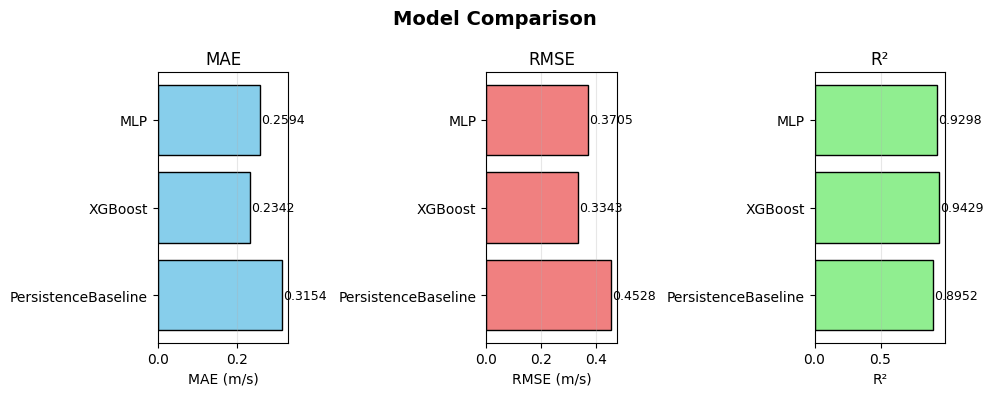

In [4]:
# Compare all models
if len(results) > 0:
    scorecard = compare(results, plot=True)
else:
    print("No models evaluated yet. Add models in the section above.")
